# Walmart Sales

We use the data from the Walmart Sales Forecasting competition. We want to predict sales for one week ahead.

In [1]:
import pandas as pd

from darts import TimeSeries
from utils import TimeseriesExperiment, Dataset


DATASET_NAME = "walmart-sales"

## Load the data

In [2]:
STORE_ID = 1

# Load data
df_train = pd.read_csv("data/walmart-sales/train.csv")
df_features = pd.read_csv("data/walmart-sales/features.csv")

# Get data from one store
df = df_train[df_train["Store"] == STORE_ID]
df = df[df["Dept"] == STORE_ID]

# Drop redundant columns
df = df.drop(["Store", "Dept", "IsHoliday"], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").resample("W").mean()


df_features = df_features.drop(
    ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"], axis=1
)
df_features = df_features[df_features["Store"] == STORE_ID]
df_features["Date"] = pd.to_datetime(df_features["Date"])
df_features = df_features.set_index("Date").resample("W").mean()

df = df.join(df_features, how="left")
df = df.drop("Store", axis=1)

df.head()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
Date,,,,,,
2010-02-07,24924.50,42.31,2.572,211.096358,8.106,0.0
2010-02-14,46039.49,38.51,2.548,211.242170,8.106,1.0
2010-02-21,41595.55,39.93,2.514,211.289143,8.106,0.0
2010-02-28,19403.54,46.63,2.561,211.319643,8.106,0.0
2010-03-07,21827.90,46.50,2.625,211.350143,8.106,0.0


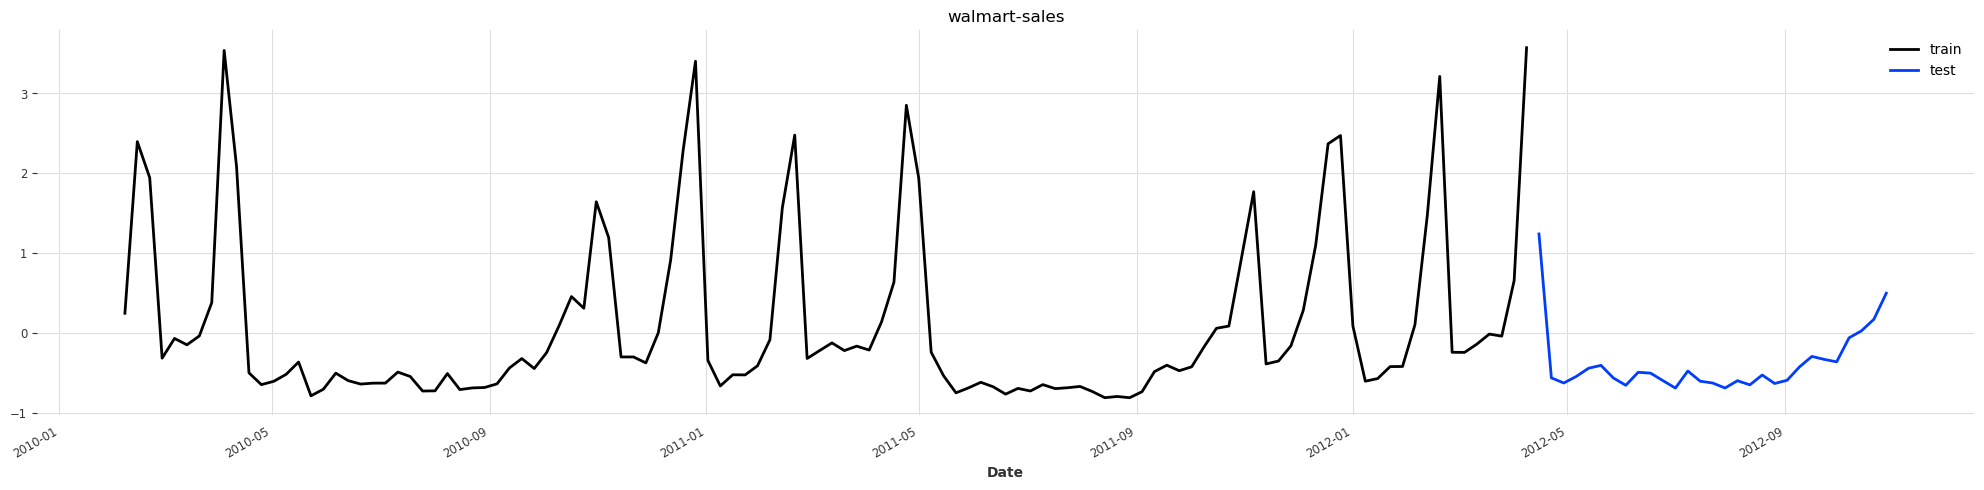

2012-04-08 00:00:00
2012-04-15 00:00:00


In [3]:
df_target = df["Weekly_Sales"]
df_features = df.drop("Weekly_Sales", axis=1)

df_future = df_features.pop("IsHoliday")
df_past = df_features

target = TimeSeries.from_series(df_target, freq="W", fill_missing_dates=True)
past_covariates = TimeSeries.from_dataframe(df_past, freq="W", fill_missing_dates=True)
future_covariates = TimeSeries.from_series(df_future, freq="W", fill_missing_dates=True)

dataset = Dataset(
    target,
    "walmart-sales",
    past_covariates=past_covariates,
    future_covariates=future_covariates,
)
dataset.plot_train_test()

print(dataset.train.time_index[-1])
print(dataset.test.time_index[0])

## Models

### Baseline

No parameters to search


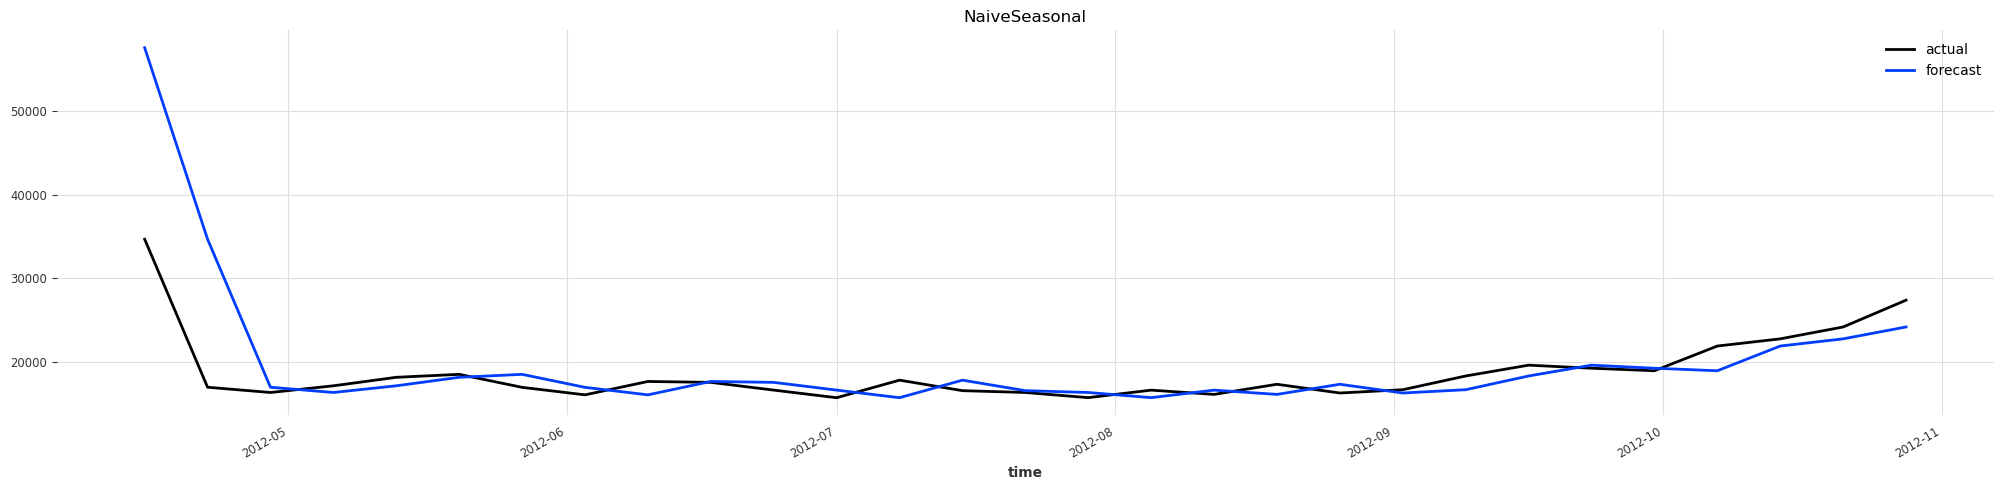

{'mape': 11.206881718246747,
 'mse': 30503061.348224156,
 'rmse': 5522.957663084532,
 'mae': 2403.6300000000006,
 'model': 'NaiveSeasonal',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1716813342.299781,
 'parameters': OrderedDict([('K', 1)])}

In [4]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)

experiment1 = TimeseriesExperiment(model, dataset, retrain=True)

experiment1.run()

In [5]:
# arima
from darts.models import ARIMA

model = ARIMA()

experiment2 = TimeseriesExperiment(
    model, dataset, {"p": [1, 3, 5], "d": [1], "q": [0]}, retrain=True
)

# experiment2.run()

In [9]:
from darts.models import XGBModel

model = XGBModel(lags=1)

experiment3 = TimeseriesExperiment(
    model,
    dataset,
    {
        "lags": [3, 7, 14],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5, 7],
        "n_estimators": [10, 25, 50, 100],
        "output_chunk_length": [1, 3],
    },
    use_pretrained_model=False,
    retrain=False,
)

experiment3.run()

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
ValueError: `past_covariates` is None in `fit()` method call, but `lags_past_covariates` is not None in constructor.


Searching for best parameters {'lags': [3, 7, 14], 'lags_past_covariates': [1, 2], 'max_depth': [3, 5, 7], 'n_estimators': [10, 25, 50, 100], 'output_chunk_length': [1, 3]}


ValueError: `past_covariates` is None in `fit()` method call, but `lags_past_covariates` is not None in constructor.

In [ ]:
from darts.models import Prophet

model_prophet = Prophet()

experiment_prophet = TimeseriesExperiment(
    model_prophet, dataset, {}, use_pretrained_model=False
)

experiment_prophet.run()

In [ ]:
from darts.models import TFTModel

model_tft = TFTModel(input_chunk_length=16, output_chunk_length=1)

params_fft = {
    "input_chunk_length": [4, 8, 16],
    "output_chunk_length": [1],
    "hidden_size": [8, 16, 32],
    "lstm_layers": [1, 2, 3],
    "num_attention_heads": [2, 4, 8],
    "dropout": [0.1, 0.2],
    "pl_trainer_kwargs": [{"accelerator": "cpu"}],
}

experiment_tft = TimeseriesExperiment(
    model_tft,
    dataset,
    params_fft,
    use_pretrained_model=False,
)

experiment_tft.run()

Searching for best parameters {'input_chunk_length': [4, 8, 16], 'output_chunk_length': [1], 'hidden_size': [8, 16, 32], 'lstm_layers': [1, 2, 3], 'num_attention_heads': [2, 4, 8], 'dropout': [0.1, 0.2], 'pl_trainer_kwargs': [{'accelerator': 'cpu'}]}


  0%|          | 0/162 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/109 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _VariableSelecti

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from darts.models.forecasting.rnn_model import RNNModel

lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    input_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "cpu"},
)

experiment_lstm = TimeseriesExperiment(lstm_model, dataset, retrain=True)

experiment_lstm.run()

## Results

In [ ]:
from utils import read_results

df = read_results()
df = df[df["dataset"] == DATASET_NAME]

df

,mape,mse,rmse,mae,model,forecast_horizon,dataset,experiment_time,parameters
1,1120912.915588,43368500155836600.0,208251050.791675,204369426.423929,XGBModel,1,walmart-sales,1716399624.963179,"{'lags': 3, 'lags_past_covariates': 1, 'lags_f..."
7,1146331.927226,55900302631044712.0,236432448.34634,217847003.036697,NaiveSeasonal,1,walmart-sales,1716399152.406511,{'K': 1}
17,1113968.735192,48338790586642440.0,219860843.686734,209906036.476923,Prophet,1,walmart-sales,1716399626.680409,"{'add_seasonalities': None, 'country_holidays'..."
22,910.973558,2.090447,1.445838,0.928657,ARIMA,3,walmart-sales,1715278529.295173,"{'p': 1, 'd': 1, 'q': 0, 'seasonal_order': [0,..."
26,1258098.127406,56638252111017728.0,237987924.296628,233635604.605595,RNNModel,1,walmart-sales,1716399729.282538,"{'model': 'LSTM', 'hidden_dim': 20, 'n_rnn_lay..."


<Axes: xlabel='model', ylabel='mse'>

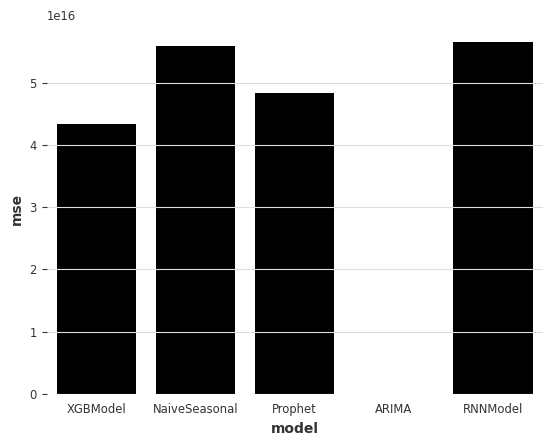

In [ ]:
import seaborn as sns

sns.barplot(data=df, x="model", y="mse")